In [1]:
## SETUP
# conda create -n stats python=2 pip numpy matplotlib pandas scipy scikit-learn seaborn ipykernel
# source activate stats
# pip install bootstrapped

#%matplotlib notebook
%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.sparse import coo_matrix
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

from math import sqrt
import json
import os, sys, re
display(HTML("<style>.container { width:100% !important; }</style>"))
# display multiple dataframes next to each other
#CSS = """
#.output {
#    flex-direction: row;
#}
#"""
#HTML('<style>{}</style>'.format(CSS))

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [6]:
task = 'RE/semeval'
#task = 'RP'
#task = 'SA'
path = '/mnt/DATA/ML/experiments/FINAL/'
#path = '/mnt/DATA/ML/experiments/SEARCH/'
parameters_final = ['model', 'linking', 'structure']
parameters_dev = ['model', 'linking', 'structure', 'st', 'fc', 'nfv', 'vvr', 'vvz', 'lr', 'kp', 'd']
dev = not '/FINAL' in path 
#best_only = True
best_only = False
print('dev=%s' % dev)
task_settings = {'RTE': 
                     {'path': path + 'entailment.tsv',
                      'metrics': ['test_accuracy_t50', 'time_s'],
                      'metrics_dev': ['dev_best_accuracy_t50', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                     },
                  'RP': 
                     {'path': path + 'relatedness.tsv',
                      'metrics': ['test_pearson_r', 'time_s'],
                      'metrics_dev': ['dev_best_pearson_r', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                     },
                  'SA': 
                     {'path': path + 'sentiment.tsv',
                      'metrics': ['test_accuracy_t50', 'time_s'],
                      'metrics_dev': ['dev_best_accuracy_t50', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                      'filters_in': [{'sl': ['500']}, {'dpth': ['50']}],
                     },
                  'RE/semeval':
                   {'path': path + 're_semeval.tsv',
                      #'metrics': ['test_f1_t33', 'f1_wo_norelation_macro', 'f1_wo_norelation_micro', 'time_s'],
                      'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': ['dev_best_f1_t33', 'time_s'],
                      'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                      'filters_out': {'dir': ['RECNN_FULLTREE'], 'm': ['LM:SUM-GRU', 'LM:MAX-GRU']},
                     },
                  'RE/tacred':
                   {'path': path + 're_tacred.tsv',
                      'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': ['dev_best_f1_t33', 'f1_wo_norelation_macro', 'f1_wo_norelation_micro', 'time_s'],
                      'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                     },
                 }

#settings = {
    #'path': '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv',
    #'path': '/mnt/DATA/ML/experiments/SEARCH/RE/SEMEVAL2010T8/re_semeval_search.tsv',
    #'path': '/mnt/DATA/ML/experiments/FINAL/entailment.tsv',
    #'metrics_task': ['pearson_r'],
    #'metrics': ['dev_best_f1_t33', 'time_s'],
    
    #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1'},
    #'metric_dev': 'dev_best_pearson_r',
    #'parameters': ['data', 'te', ''], # entries from run_desc
    #'parameters': ['m', 'st', 'fc', 'dir', 'l', 'nfv', 'vvr', 'vvz']
    #'parameters':
    #'select': {'m': ['GRU', 'SUM-GRU']}
#}
task_setting = task_settings[task]
#path = '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv'
#metrics_task = ['pearson_r']
path = task_setting['path']
#metrics_task = settings['metrics_task']
if dev:
    metrics = task_setting['metrics_dev']
else:
    metrics = task_setting['metrics']
print('use metrics: %s' % metrics)
metrics_alternative = task_setting.get('metrics_alternative', {})
parameters = task_setting['parameters']
print('use parameters: %s' % parameters)
select = task_setting.get('select', {})
df_loaded = pd.read_csv(path, sep='\t')

filters_in = task_setting.get('filters_in', None)
filters_out = task_setting.get('filters_out', None)
figsize = (10, 5)

#df_loaded.apply(lambda row: row['dev_best_recall@1'] or row['dev_best_f1_t33'],axis=1)
for m_alt in metrics_alternative: 
    df_loaded[m_alt].fillna(df_loaded[metrics_alternative[m_alt]], inplace=True)

def get_current_values(df):
    return {p: list(set(df[p])) for p in parameters}


# exclude: dir==RECNN_FULLTREE
#df_loaded = df_loaded[df_loaded['dir'] != 'RECNN_FULLTREE']
#df_loaded.drop(df_loaded[df_loaded['dir'] == 'RECNN_FULLTREE'].index, axis=0, inplace=True)
#df_loaded.reset_index(drop=True, inplace=True)
print('loaded %i records' % len(df_loaded))

dev=False
use metrics: ['test_f1_t33', 'time_s']
use parameters: ['model', 'linking', 'structure']
loaded 997 records


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_loaded[-10:]
#df_loaded[['tree_embedder', metrics[0]]].groupby('tree_embedder').count()
#df_loaded[df_loaded['tree_embedder'] == 'HTUBatchedHead_reduceMAX_mapGRU'][:10]

,bidirectional,dev_best_accuracy_t33,dev_best_accuracy_t50,dev_best_accuracy_t66,dev_best_f1_t33,dev_best_f1_t50,dev_best_f1_t66,dev_best_precision_t33,dev_best_precision_t50,dev_best_precision_t66,dev_best_recall@1,dev_best_recall@2,dev_best_recall@3,dev_best_recall@5,dev_best_recall_t33,dev_best_recall_t50,dev_best_recall_t66,dev_file_indices,dir,keep_prob,leaf_fc_size,run_desc,run_description,steps_train,test_accuracy_t33,test_accuracy_t50,test_accuracy_t66,test_f1_t33,test_f1_t50,test_f1_t66,test_precision_t33,test_precision_t50,test_precision_t66,test_recall@1,test_recall@2,test_recall@3,test_recall@5,test_recall_t33,test_recall_t50,test_recall_t66,time_s,tree_embedder
987,NaN,0.950594,0.955466,0.957473,0.536871,0.523088,0.496100,0.529842,0.599354,0.659067,NaN,NaN,NaN,NaN,0.544090,0.464040,0.397749,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,576,0.953068,0.957585,0.959252,0.560856,0.550719,0.518993,0.552538,0.622274,0.685196,NaN,NaN,NaN,NaN,0.569429,0.493923,0.417680,89.984387,FLAT_SUM
988,NaN,0.952075,0.957441,0.958296,0.543001,0.524807,0.479671,0.545054,0.636364,0.698565,NaN,NaN,NaN,NaN,0.540963,0.446529,0.365228,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,384,0.951924,0.956770,0.958224,0.545455,0.519189,0.477576,0.542868,0.626105,0.698582,NaN,NaN,NaN,NaN,0.548066,0.443462,0.362799,79.525930,FLAT_SUM
989,NaN,0.950759,0.955861,0.956947,0.532792,0.485616,0.426316,0.532127,0.627976,0.713656,NaN,NaN,NaN,NaN,0.533458,0.395872,0.303940,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,320,0.952758,0.957507,0.957798,0.546267,0.512889,0.449000,0.552334,0.646499,0.717638,NaN,NaN,NaN,NaN,0.540331,0.425046,0.326703,78.502982,FLAT_SUM
990,NaN,0.951384,0.956321,0.957868,0.552289,0.543830,0.515152,0.535882,0.603817,0.653218,NaN,NaN,NaN,NaN,0.569731,0.494684,0.425266,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,640,0.950741,0.955956,0.957817,0.549228,0.541935,0.512108,0.529774,0.598664,0.654441,NaN,NaN,NaN,NaN,0.570166,0.495028,0.420626,95.064150,FLAT_SUM
991,NaN,0.951516,0.956321,0.957078,0.533418,0.505035,0.444160,0.540436,0.625693,0.697456,NaN,NaN,NaN,NaN,0.526579,0.423390,0.325829,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,384,0.953746,0.958496,0.958457,0.557493,0.530997,0.467313,0.561449,0.655135,0.718654,NaN,NaN,NaN,NaN,0.553591,0.446409,0.346225,80.295134,FLAT_SUM
992,NaN,0.957210,0.961423,0.962180,0.600000,0.569434,0.521449,0.590551,0.690116,0.780549,NaN,NaN,NaN,NaN,0.609756,0.484678,0.391495,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,448,0.957933,0.961791,0.961830,0.603581,0.577492,0.517520,0.598768,0.690769,0.773060,NaN,NaN,NaN,NaN,0.608471,0.496133,0.388950,83.858442,FLAT_MAX
993,NaN,0.955038,0.959185,0.961357,0.587809,0.578518,0.554628,0.567930,0.633656,0.704918,NaN,NaN,NaN,NaN,0.609131,0.532208,0.457161,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,704,0.954871,0.959523,0.960686,0.585322,0.584891,0.556624,0.566747,0.635421,0.684777,NaN,NaN,NaN,NaN,0.605157,0.541805,0.468877,99.851579,FLAT_MAX
994,NaN,0.956124,0.960172,0.961588,0.581213,0.547833,0.508632,0.583965,0.680594,0.778351,NaN,NaN,NaN,NaN,0.578487,0.458411,0.377736,"8,9",BOW,0.9,250.0,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,aEDG_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_cntxt0...,448,0.958360,0.961985,0.961403,0.606016,0.577280,0.518966,0.603581,0.695946,0.754213,NaN,NaN,NaN,NaN,0.608471,0.493186,0.395580,85.329396,FLAT_MAX
995,NaN,0.956321,0.960765,0.961127,0.591063,0.560148,0.498514,0.582625,0.683168,0.776455,NaN,NaN,NaN,NaN,0.599750,0.474672,0.

In [8]:
COLUMN_RUN = 'run'
COLUMN_RUN_DESC_COLS = 'run_desc_cols'
COLUMN_DFIDX = 'dfidx'
COLUMN_RUN_DESC = 'run_description'
COLUMN_RUN_DESC_NEW = 'run_desc'

map_value_short = {'CORENLPNONERRECEMBEDGESMC2': 'E', 
             'CORENLPNONERRECEMBMC2': 'D',
             #'HTUREDUCEMAXMAPGRU': 'MAX-GRU',
             #'HTUREDUCESUMMAPGRU': 'SUM-GRU',
             #'FLATGRU': 'GRU',
             #'FLATSUM': 'SUM',
             #'FLATMAX': 'MAX',
            }
map_value_long = {'E': 'edges', 'D': 'direct'}
map_param_short = {'data': 'l', 'te': 'm', 'linking': 'l', 'model': 'm', 'structure': 'str'}
map_param_long = {'l': 'linking', 'm': 'model', 'str': 'structure'}
map_task_long = {'RTE': 'Rogognizing Textual Entailment', 'RP': 'Relatedness Prediction', 'SA': 'Sentiment Analysis', 'RE/semeval': 'Relation Extraction (SemEval)', 'RE/tacred': 'Relation Extraction (TacRED)'}
metrics_inverted = ['time_s', 'steps_train']
parameters = [map_param_short.get(p, p) for p in parameters]

def as_suffixes(v, suffixes):
    found = []
    for suffix in suffixes:
        if suffix in v:
            found.append(suffixes[suffix])
            v = v.replace(suffix, '')
    return v + (':' + '-'.join(found) if len(found) > 0 else '')

def format_model(m):
    if m.startswith('FLAT'):
        m = 'FLAT:' + m[len('FLAT'):]
    elif m.startswith('HTU'):
        m = m[len('HTU'):]
        m = m.replace('REDUCE','').replace('MAP','-')
        m = as_suffixes(m, {'REV':'REV', 'WD':'WD', 'IS':'IS', 'PL':'PL'})
        if m.startswith('BATCHEDHEAD'):
            m = 'LM:' + m[len('BATCHEDHEAD'):]
        else:
            m = 'TREE:' + m
       
    return m

def format_data(v):
    if 'SPAN' in v:
        return 'SPAN'
    if 'EDGES' in v:
        return 'EDGES'
    return 'DIRECT'

def get_value_short(v, t=None):
    res = v
    #try:
    #    float(v)
    #    return v
    #except ValueError:
    #    pass
     
    if isinstance(res, str):
        if t == 'te':
            res = format_model(res)
        elif t == 'data':
            res = format_data(v)
        else:
            parts = res.split('-')
            if parts[0] != '':
                res = ','.join(parts)
        #res = format_model(res)
        
    return res

def get_structure_type(v):
    if v.startswith('TREE:'):
        return 'RECNN'
    if v.startswith('LM:'):
        return 'LM'
    if v.startswith('FLAT:'):
        if v.startswith('FLAT:GRU') or v.startswith('FLAT:LSTM'):
            return 'RNN'
        if v.startswith('FLAT:SUM') or v.startswith('FLAT:MAX'):
            return 'BOW'
        raise AssertionError('unknown flat model: %s' % v)
    raise AssertionError('unknown model: %s' % v)
    
def run_desc_to_dict(run_desc):
    _res = {}
    parts = run_desc.split('/')
    if len(parts) == 2:
        _res[COLUMN_RUN] = parts[1]
    elif len(parts) > 2:
        print('WARNINING: more then 2 parts for split with "/": %s' % run_desc)
    else:
        print('WARNINING: no split_idx found: %s' % run_desc)
    run_desc = parts[0]
    parts = re.split(r'(_|^)([a-z]+)', run_desc)
    #new_entries = {parts[i-1]: ','.join(parts[i].strip().split('-')) for i in range(3, len(parts), 3)}
    new_entries = {map_param_short.get(parts[i-1], parts[i-1]): get_value_short(parts[i], parts[i-1]) for i in range(3, len(parts), 3)}
    _res.update(new_entries)
    cols_run_desc = sorted([k for k in new_entries if k not in [COLUMN_RUN, COLUMN_DFIDX]])
    _res[COLUMN_RUN_DESC_COLS] = ','.join(cols_run_desc)
    _res[COLUMN_RUN_DESC_NEW] = '_'.join([col + _res[col] for col in cols_run_desc])
    return _res

#run_desc_to_dict('a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBEDGESMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0')
#pd.DataFrame(df['run_description'].apply(run_desc_to_dict))#, axis=1, result_type='expand')
df_runddesc = pd.DataFrame([run_desc_to_dict(rd) for rd in df_loaded[COLUMN_RUN_DESC]])
#metrics_test = ['test_' + m for m in metrics_task]
#metrics_dev_best = ['dev_best_' + m for m in metrics_task]
#metrics_performance = metrics_dev_best + metrics_test
#metrics_resources = ['steps_train', 'time_s'] 
#metrics_all = metrics_performance + metrics_resources
take_columns = list(metrics) + ['dir']
for m in task_setting['metrics_dev']:
    if m not in metrics:
        take_columns.append(m)
df_all = pd.concat([df_loaded[take_columns], df_runddesc], axis=1)
# add structure column
df_all['str'] = df_all.apply(lambda row: get_structure_type(row['m']), axis=1)

if best_only:
    print('keep only runs with max %s ...' % task_setting['metrics_dev'])
    n = len(df_all)
    df_all = df_all.sort_values(task_setting['metrics_dev'], ascending=False).drop_duplicates(['run_desc', 'run'])
    print('removed %i of %i runs (%i remaining)' % (n - len(df_all), n, len(df_all)))
else:
    print('loaded %i runs' % len(df_all))

# remove (wrong) entries with max metric 
df_all = df_all[df_all[metrics[0]] < 1.0]

if filters_in is not None:
    print('use filters_in: %s' % filters_in)
    filtered_dfs = [] 
    for fil in filters_in:
        filtered_df = df_all
        for fil_k in fil:
            filtered_df = filtered_df[filtered_df[fil_k].isin(fil[fil_k])]
        filtered_dfs.append(filtered_df)
    df_all = pd.concatenate(filtered_dfs)

    
if filters_out is not None:
    print('use filters_out: %s' % filters_out)
    for fil_k in filters_out:
        df_all = df_all[~df_all[fil_k].isin(filters_out[fil_k])]

df_all.reset_index(drop=True, inplace=True)
print('%i records remain' % len(df_all))
        
#df_all.apply (lambda row: row['dev_best_recall@1'],axis=1)
#df_all[:20]#.describe()
#set(df_all['m'])
#df_all[:100]
#print('%i runs' % len(df_all))
#df_all[df_all['str'] == 'BOW'][:10]
#len(df_all)
#df_all['run_desc'][:10].values
#set(df_all['kpb'])
run_desc_cols = df_all['run_desc_cols'][0].split(',')
run_desc_cols.insert(0, run_desc_cols.pop(run_desc_cols.index('m')))
print('run_desc_cols: %s' % run_desc_cols)
df_all[:10]

loaded 997 runs
use filters_out: {'m': ['LM:SUM-GRU', 'LM:MAX-GRU'], 'dir': ['RECNN_FULLTREE']}
767 records remain
run_desc_cols: ['m', 'a', 'avf', 'b', 'bs', 'cc', 'clp', 'cm', 'cntxt', 'd', 'dpth', 'dt', 'ec', 'fc', 'kp', 'kpb', 'kpn', 'l', 'lc', 'leaffc', 'lr', 'mt', 'n', 'nfv', 'ns', 'rootfc', 'sl', 'sm', 'st', 'tfidf', 'tk', 'vvr', 'vvz']


,test_f1_t33,time_s,dir,dev_best_f1_t33,a,avf,b,bs,cc,clp,cm,cntxt,d,dfidx,dpth,dt,ec,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc,run_desc_cols,sl,sm,st,tfidf,tk,vvr,vvz,str
0,0.775444,184.701627,RECNN,0.771515,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,0,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
1,0.760179,193.063972,RECNN,0.774213,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,1,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
2,0.767554,205.665980,RECNN,0.777913,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,2,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
3,0.771209,204.337677,RECNN,0.776228,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,3,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
4,0.765139,277.850749,RECNN,0.778691,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,4,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
5,0.761701,160.382081,RECNN,0.768440,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:SUM-GRU,MULTICLASS,10000,F,20,,0,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
6,0.759849,263.099699,RECNN,0.773130,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:SUM-GRU,MULTICLASS,10000,F,20,,1,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
7,0.762364,131.265570,RECNN,0.759540,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:SUM-GRU,MULTICLASS,10000,F,20,,2,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
8,0.761667,247.721865,RECNN,0.768389,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:SUM-GRU,MULTICLASS,10000,F,20,,3,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN
9,0.766372,300.186682,RECNN,0.768107,EDG,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,SPAN,-1,0,0.001,TREE:SUM-GRU,MULTICLASS,10000,F,20,,4,"aEDG_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTRE...","a,avf,b,bs,cc,clp,cm,cntxt,d,dpth,dt,ec,fc,kp,...",50,,250,F,RELS,F,F,RECNN


In [9]:
df_all[['m'] + metrics].groupby(['m']).agg(["count", "mean"])

test_f1_t33           time_s             
                       count      mean  count         mean
m                                                         
FLAT:GRU                  50  0.721518     50   374.487930
FLAT:MAX                  50  0.665646     50    80.911413
FLAT:SUM                  50  0.632142     50    84.075009
LM:MAX-GRU:IS-WD          45  0.742247     45  3422.321234
LM:MAX-GRU:WD             30  0.741608     30  3288.211263
LM:SUM-GRU:WD             34  0.731318     34  3516.668020
TREE:MAX-GRU              85  0.757596     85   297.928815
TREE:MAX-GRU:IS           65  0.759735     65   312.083196
TREE:MAX-GRU:PL           65  0.742037     65   303.880024
TREE:MAX-GRU:WD           60  0.749671     60   333.737155
TREE:SUM-GRU              68  0.729546     68   278.628687
TREE:SUM-GRU:IS           55  0.736696     55   278.522757
TREE:SUM-GRU:PL           55  0.729311     55   303.157503
TREE:SUM-GRU:WD           55  0.724052     55   314.864182

In [14]:
df_all[run_desc_cols + metrics][df_all['l'].isin(['DIRECT', 'EDGES'])].groupby(run_desc_cols).agg(["count", "mean"])

test_f1_t33  \
                                                                                                                                                                                       count   
m                a   avf b            bs  cc clp cm        cntxt d dpth dt ec fc  kp  kpb kpn l      lc leaffc lr    mt         n     nfv ns rootfc sl sm st  tfidf tk   vvr vvz               
FLAT:GRU         EDG F                100 F  5.0 AGGREGATE 0     F 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            25   
FLAT:MAX         EDG F                100 F  5.0 AGGREGATE 0     F 20   F     750 0.9 1.0 1.0 DIRECT -1 250    0.001 MULTICLASS 10000 F   20        50    0   F     RELS F   F            25   
FLAT:SUM         EDG F                100 F  5.0 AGGREGATE 0     F 20   F     750 0.9 1.0 1.0 DIRECT -1 250    0.001 MULTICLASS 10000 F   20        50    0   F     RELS F   F            25   
LM:MAX-GRU:IS-WD     F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 EDGES  -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            20   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 DIRECT -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            25   
LM:MAX-GRU:WD        F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 EDGES  -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            15   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 DIRECT -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            15   
LM:SUM-GRU:WD        F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 EDGES  -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            17   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     0   0.7 1.0 1.0 DIRECT -1 0      0.003 LM         10000 F   20 0      50 F  250 F     RELS F   T            17   
TREE:MAX-GRU         F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 EDGES  -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            15   
                                                                 T 20   F     750 0.5 1.0 1.0 EDGES  -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            10   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            25   
                                                                 T 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            10   
TREE:MAX-GRU:IS      F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 EDGES  -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            15   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            25   
TREE:MAX-GRU:PL      F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 EDGES  -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            15   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            25   
TREE:MAX-GRU:WD      F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 EDGES  -1 0      0.001 MULTICLASS 10000 F   20        50    250 F     RELS F   F            10   
                 EDG F   POS,NIFW,PAR 100 F  5.0 TREE      0     F 20   F     750 0.5 1.0 1.0 DIRECT -1 0      0.001 MULTICLASS 10000 F   20     

In [11]:
def reformat_ttest_dict(t_test_results, metric, index_names, index_split='/', sort_by=None, dont_show_all=False, pivot_table_columns=None):
    results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results_df.columns = ['statistic','pvalue', 'mean_a', 'mean_b', 'nbr_a', 'nbr_b']
    results_df.index = pd.MultiIndex.from_tuples([idx.split(index_split) for idx in results_df.index.values], names=index_names)
    
    if not dont_show_all:
        if 'metric' in index_names:
            display(results_df.xs(metric, level='metric').sort_index())
        else:
            display(results_df.sort_index())

    #m = metrics[0]
    #best_settings[m][parameters].sort_values(by=p)

    #display(pd.DataFrame(best_settings[m][[m] + parameters].sort_values(by=p)[m].values - second_settings[m][[m] + parameters].sort_values(by=p)[m].values))
    #display(best_settings[m][parameters].sort_values(by=p))
    #display(second_settings[m][parameters].sort_values(by=p))

    #results_df.xs('dev_best_f1_t33', level='metric')
    results_df['dif'] = results_df.apply(lambda row: row['mean_b'] - row['mean_a'], axis=1)
    results_df['dif_%'] = results_df.apply(lambda row: (row['dif'] / row['mean_a']), axis=1)
    results_df['a.05'] = results_df.apply(lambda row: row['pvalue'] < 0.05, axis=1)
    results_df['a.01'] = results_df.apply(lambda row: row['pvalue'] < 0.01, axis=1)
    #x = results_df.xs(metrics[0], level='metric').sort_values('dif_%')
    #x = x.iloc[(-np.abs(x['dif_%'].values)).argsort()]
    #x = x.xs(metrics[0], level='v')
    x = results_df.reset_index()
    if 'metric' in index_names:
        x = x[x['metric'] == metric]
    #x = x[x['v'].str.startswith('TREE')]
    #x = x[x['sub_p'] == 'st']
    #x = x[(x['nbr_a'] >= 5) & (x['nbr_b'] >= 5)]
    #x = x[x[]]
    if sort_by is not None:
        print('decrease:')
        display(x[x['a.05'] & (x['dif'] < 0)].sort_values(sort_by))
        print('increase:')
        display(x[x['a.05'] & (x['dif'] > 0)].sort_values(sort_by))
    else:
        print('decrease:')
        display(x[x['a.05'] & (x['dif'] < 0)])
        print('increase:')
        display(x[x['a.05'] & (x['dif'] > 0)])
    
    if pivot_table_columns is not None:
        row_col, col_col, value_col = pivot_table_columns
        x_p = x[x['a.01']]
        #vals = x_pt[value_col].values
        #cols = x_pt[col_col].tolist()
        #rows = x_pt[row_col].tolist()
        #all_labels = sorted(list(set(cols + rows)))
        #labels_map = {l: i for i, l in enumerate(all_labels)}
        #coo = coo_matrix((vals, ([labels_map[l] for l in rows], [labels_map[l] for l in cols])), shape=(len(all_labels), len(all_labels)))
        #print(coo.toarray())
        
        pt = pd.pivot_table(x_p, values=value_col, index=[row_col], columns=[col_col])#, fill_value=0)

        #display(pt.style.background_gradient(cmap='summer').highlight_null('grey'))
        #cm = sns.light_palette("green", as_cmap=True)
        cm = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
        #cm = ListedColormap(sns.color_palette("BrBG", 7).as_hex())
        
        display(pt.style.background_gradient(cmap=cm).highlight_null('grey'))
        
        

In [12]:
cvs = get_current_values(df_all)

# List of selectors. Each selector is a dict with { parameter -> list of allowd values }. 
# The rows of all selector resulats are concatenated.
# Example:
# selectors = [{'m': ['TREE:SUM-GRU']}]
#selectors = [{'str': ['LM']}]
#selectors = [{'l': ['EDGE']}]
selectors = [{'l': ['EDGES']}]
p = 'str'
metric_main = metrics[0]
#parameters = ['m', 'str']

print('check parameter: %s' % p)
best_values = {m: [] for m in metrics}
best_settings = {m: [] for m in metrics}
second_settings = {m: [] for m in metrics}
t_test_results = {}
for m in metrics:
    for v in cvs[p]:
        df_selected = []
        all_selectors = [{}] if len(selectors) == 0 else selectors
        current_selectors = []
        for selector in all_selectors:
            selector_current = selector.copy()
            selector_current.update({p: [v]})
            current_selectors.append(selector_current)
            #selector_current= {p: [v]}
            #print('select: %s=%s' % (p, v))
            #print(select)
            df_selected_current = df_all
            for selector_key in selector_current:
                df_selected_current = df_selected_current[df_selected_current[selector_key].isin(selector_current[selector_key])]
            df_selected.append(df_selected_current)
        
        df_selected = pd.concat(df_selected, axis=0)
        #print(len(df_selected))
        #print(len(df_selected))
        #for m in metrics:
        grouped = df_selected.sort_values(metrics[0], ascending=(m in metrics_inverted)).drop_duplicates(parameters)
        #print(len(grouped))
        #print(len(grouped))
        if len(grouped) == 0:
            print('no run for: %s' % str(current_selectors))
            continue
        best_settings[m].append(grouped.iloc[0])
        if len(grouped) > 1:
            second_settings[m].append(grouped.iloc[1])
        else:
            print('warning: only one (best) setting found for: %s' % str(current_selectors))
            #continue
        for sub_p in parameters:
            if sub_p == p:
                
                continue
            #print
            grouped = df_selected.groupby(by=sub_p)
            grouped_keys = list(grouped.groups)
            for i, group_a in enumerate(grouped_keys):
                for group_b in grouped_keys[i + 1:]:
                    #print('%s: %s -> %s' % (sub_p, group_a, group_b))
                    #if v == 'BOW':
                    #    print(grouped.get_group(group_a)[m].dropna())
                    #    print(grouped.get_group(group_b)[m].dropna())
                    
                    values_a = grouped.get_group(group_a)[m].dropna().values
                    values_b = grouped.get_group(group_b)[m].dropna().values
                    #if len(values_a) == 0 or len(values_b) == 0:
                    #    continue
                    values_a_mean = np.mean(values_a)
                    values_b_mean = np.mean(values_b)
                    #print(values_a)
                    #print(values_b)
                    t_test_results['%s|%s|%s|%s|(%s -> %s)' % (m, p, v, sub_p, group_a, group_b)] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
            #for k in grouped.groups:
                #print(k)
        #best_values[m].append(best_settings[m][m])
        #print('best setting for metric: %s=%f' % (m, _best[m]))
        #print(_best[parameters])
        #print
best_settings = {m: pd.DataFrame(best_settings[m]) for m in metrics}
second_settings = {m: pd.DataFrame(second_settings[m]) for m in metrics}

reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'v', 'sub_p', 'change'), index_split='|', sort_by=['sub_p', 'change'])#, dont_show_all=True)

check parameter: str
no run for: [{'l': ['EDGES'], 'str': ['RNN']}]
no run for: [{'l': ['EDGES'], 'str': ['BOW']}]
no run for: [{'l': ['EDGES'], 'str': ['RNN']}]
no run for: [{'l': ['EDGES'], 'str': ['BOW']}]


statistic        pvalue  \
p   v     sub_p change                                                          
str LM    m     (LM:MAX-GRU:IS-WD -> LM:MAX-GRU:WD)   -0.537992  5.941929e-01   
                (LM:MAX-GRU:IS-WD -> LM:SUM-GRU:WD)    2.361899  2.387461e-02   
                (LM:MAX-GRU:WD -> LM:SUM-GRU:WD)       2.480317  1.896222e-02   
    RECNN m     (TREE:MAX-GRU -> TREE:MAX-GRU:IS)     -0.172102  8.642708e-01   
                (TREE:MAX-GRU -> TREE:MAX-GRU:WD)      6.677687  1.331848e-07   
                (TREE:MAX-GRU -> TREE:SUM-GRU)        15.001529  4.610284e-17   
                (TREE:MAX-GRU -> TREE:SUM-GRU:IS)      8.710342  1.848600e-09   
                (TREE:MAX-GRU -> TREE:SUM-GRU:PL)     14.435018  1.697711e-14   
                (TREE:MAX-GRU -> TREE:SUM-GRU:WD)     19.706762  5.973951e-18   
                (TREE:MAX-GRU:IS -> TREE:MAX-GRU:WD)   7.574490  1.081291e-07   
                (TREE:MAX-GRU:IS -> TREE:SUM-GRU:IS)   9.811381  1.196230e-08   
                (TREE:MAX-GRU:IS -> TREE:SUM-GRU:WD)  22.304502  1.454369e-14   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU)     -7.844173  1.827352e-09   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU:IS)  -8.370686  4.175200e-09   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU:WD)  -0.167595  8.683667e-01   
                (TREE:MAX-GRU:PL -> TREE:SUM-GRU)      8.526674  5.242836e-09   
                (TREE:MAX-GRU:PL -> TREE:SUM-GRU:IS)   4.657351  1.959432e-04   
                (TREE:MAX-GRU:PL -> TREE:SUM-GRU:PL)  11.763051  6.952376e-10   
                (TREE:MAX-GRU:PL -> TREE:SUM-GRU:WD)  18.095760  5.377997e-13   
                (TREE:MAX-GRU:WD -> TREE:SUM-GRU:WD)  18.522080  9.983477e-11   
                (TREE:SUM-GRU -> TREE:MAX-GRU:IS)    -14.205566  9.143651e-14   
                (TREE:SUM-GRU -> TREE:MAX-GRU:WD)     -7.567431  1.984239e-07   
                (TREE:SUM-GRU -> TREE:SUM-GRU:IS)     -2.288070  3.608127e-02   
                (TREE:SUM-GRU -> TREE:SUM-GRU:WD)      6.056120  1.666172e-05   
                (TREE:SUM-GRU:IS -> TREE:MAX-GRU:WD)  -4.784758  3.564562e-04   
                (TREE:SUM-GRU:IS -> TREE:SUM-GRU:WD)   9.541843  1.203355e-05   
                (TREE:SUM-GRU:PL -> TREE:MAX-GRU:IS) -16.532952  2.503662e-12   
                (TREE:SUM-GRU:PL -> TREE:MAX-GRU:WD) -12.248443  1.633737e-08   
                (TREE:SUM-GRU:PL -> TREE:SUM-GRU)     -1.939912  7.022687e-02   
                (TREE:SUM-GRU:PL -> TREE:SUM-GRU:IS)  -5.011591  1.037702e-03   
                (TREE:SUM-GRU:PL -> TREE:SUM-GRU:WD)   5.147893  8.765885e-04   

                                                        mean_a    mean_b  \
p   v     sub_p change                                                     
str LM    m     (LM:MAX-GRU:IS-WD -> LM:MAX-GRU:WD)   0.742799  0.746004   
                (LM:MAX-GRU:IS-WD -> LM:SUM-GRU:WD)   0.742799  0.730105   
                (LM:MAX-GRU:WD -> LM:SUM-GRU:WD)      0.746004  0.730105   
    RECNN m     (TREE:MAX-GRU -> TREE:MAX-GRU:IS)     0.755229  0.755624   
                (TREE:MAX-GRU -> TREE:MAX-GRU:WD)     0.755229  0.738058   
                (TREE:MAX-GRU -> TREE:SUM-GRU)        0.755229  0.712827   
                (TREE:MAX-GRU -> TREE:SUM-GRU:IS)     0.755229  0.723655   
                (TREE:MAX-GRU -> TREE:SUM-GRU:PL)     0.755229  0.703842   
                (TREE:MAX-GRU -> TREE:SUM-GRU:WD)     0.755229  0.684506   
                (TREE:MAX-GRU:IS -> TREE:MAX-GRU:WD)  0.755624  0.738058   
                (TREE:MAX-GRU:IS -> TREE:SUM-GRU:IS)  0.755624  0.723655   
                (TREE:MAX-GRU:IS -> TREE:SUM-GRU:WD)  0.755624  0.684506   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU)     0.737697  0.755229   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU:IS)  0.737697  0.755624   
                (TREE:MAX-GRU:PL -> TREE:MAX-GRU:WD)  0.737697  0.738058   
                (TREE:MAX-GRU:PL -> TREE:SUM-GRU)     0.737697  0.712827   
            

decrease:


,metric,p,v,sub_p,change,statistic,pvalue,mean_a,mean_b,nbr_a,nbr_b,dif,dif_%,a.05,a.01
15,test_f1_t33,str,LM,m,(LM:MAX-GRU:IS-WD -> LM:SUM-GRU:WD),2.361899,2.387461e-02,0.742799,0.730105,20,17,-0.012694,-0.017090,True,False
28,test_f1_t33,str,LM,m,(LM:MAX-GRU:WD -> LM:SUM-GRU:WD),2.480317,1.896222e-02,0.746004,0.730105,15,17,-0.015899,-0.021312,True,False
38,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU -> TREE:MAX-GRU:WD),6.677687,1.331848e-07,0.755229,0.738058,25,10,-0.017171,-0.022736,True,True
20,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU -> TREE:SUM-GRU),15.001529,4.610284e-17,0.755229,0.712827,25,13,-0.042402,-0.056145,True,True
61,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU -> TREE:SUM-GRU:IS),8.710342,1.848600e-09,0.755229,0.723655,25,5,-0.031574,-0.041807,True,True
45,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU -> TREE:SUM-GRU:PL),14.435018,1.697711e-14,0.755229,0.703842,25,5,-0.051387,-0.068041,True,True
23,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU -> TREE:SUM-GRU:WD),19.706762,5.973951e-18,0.755229,0.684506,25,5,-0.070723,-0.093644,True,True
59,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU:IS -> TREE:MAX-GRU:WD),7.574490,1.081291e-07,0.755624,0.738058,15,10,-0.017567,-0.023248,True,True
36,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU:IS -> TREE:SUM-GRU:IS),9.811381,1.196230e-08,0.755624,0.723655,15,5,-0.031970,-0.042309,True,True
24,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU:IS -> TREE:SUM-GRU:WD),22.304502,1.454369e-14,0.755624,0.684506,15,5,-0.071118,-0.094118,True,True


increase:


,metric,p,v,sub_p,change,statistic,pvalue,mean_a,mean_b,nbr_a,nbr_b,dif,dif_%,a.05,a.01
35,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU:PL -> TREE:MAX-GRU),-7.844173,1.827352e-09,0.737697,0.755229,15,25,0.017532,0.023765,True,True
7,test_f1_t33,str,RECNN,m,(TREE:MAX-GRU:PL -> TREE:MAX-GRU:IS),-8.370686,4.175200e-09,0.737697,0.755624,15,15,0.017927,0.024302,True,True
43,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU -> TREE:MAX-GRU:IS),-14.205566,9.143651e-14,0.712827,0.755624,13,15,0.042798,0.060039,True,True
29,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU -> TREE:MAX-GRU:WD),-7.567431,1.984239e-07,0.712827,0.738058,13,10,0.025231,0.035396,True,True
55,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU -> TREE:SUM-GRU:IS),-2.288070,3.608127e-02,0.712827,0.723655,13,5,0.010828,0.015190,True,False
8,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU:IS -> TREE:MAX-GRU:WD),-4.784758,3.564562e-04,0.723655,0.738058,5,10,0.014403,0.019903,True,True
42,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU:PL -> TREE:MAX-GRU:IS),-16.532952,2.503662e-12,0.703842,0.755624,5,15,0.051782,0.073571,True,True
13,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU:PL -> TREE:MAX-GRU:WD),-12.248443,1.633737e-08,0.703842,0.738058,5,10,0.034216,0.048613,True,True
4,test_f1_t33,str,RECNN,m,(TREE:SUM-GRU:PL -> TREE:SUM-GRU:IS),-5.011591,1.037702e-03,0.703842,0.723655,5,5,0.019813,0.028149,True,True


In [8]:
best_settings[metric_main]

,test_accuracy_t50,time_s,dev_best_accuracy_t50,a,avf,b,bs,cc,clp,cm,cntxt,d,dfidx,dpth,dt,ec,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc,sl,sm,st,tfidf,tk,vvr,vvz,str
54,0.910356,2398.0501,0.9038,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",50,F,,400,0.9,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,MULTICLASS,10000,F,20,,4,"a_avfF_bPOS,NIFW,PAR_bs100_ccF_clp5.0_cmTREE_c...",500,,350,F,STM,F,F,RECNN


In [9]:
t_test_results = {}
parameter_values_all = []
for m in metrics:
    print('metric=%s' % m)
    values = {}
    for i, row in enumerate(best_settings[m][parameters].to_dict('records')):
        #print(row)
        values[json.dumps(row)] = df_all.loc[(df_all[list(row)] == pd.Series(row)).all(axis=1)][m].dropna().values
        if len(parameter_values_all) <= i:
            parameter_values_all.append(row[p])
        else:
            assert parameter_values_all[i] == row[p], 'inconsistent parameter value'
        
    #print(values)
    
    values_keys = list(values.keys())
    for i, s_a in enumerate(values_keys):
        for s_b in values_keys[i+1:]:
            #print('%s/%s/%s' % (m, s_a, s_b))
            values_a = values[s_a]
            values_b = values[s_b]
            mean_a = np.mean(values_a)
            mean_b = np.mean(values_b)
            t_test_results['%s|%s|%s' % (m, s_a, s_b)] = st.ttest_ind(values_a, values_b) + (mean_a, mean_b, len(values_a), len(values_b))

reformat_ttest_dict(t_test_results, metric=metrics[0], index_split='|', index_names=('metric', 'a', 'b'), pivot_table_columns=('a', 'b', 'dif_%'))



metric=test_accuracy_t50
metric=time_s


ValueError: Length mismatch: Expected axis has 0 elements, new values have 6 elements

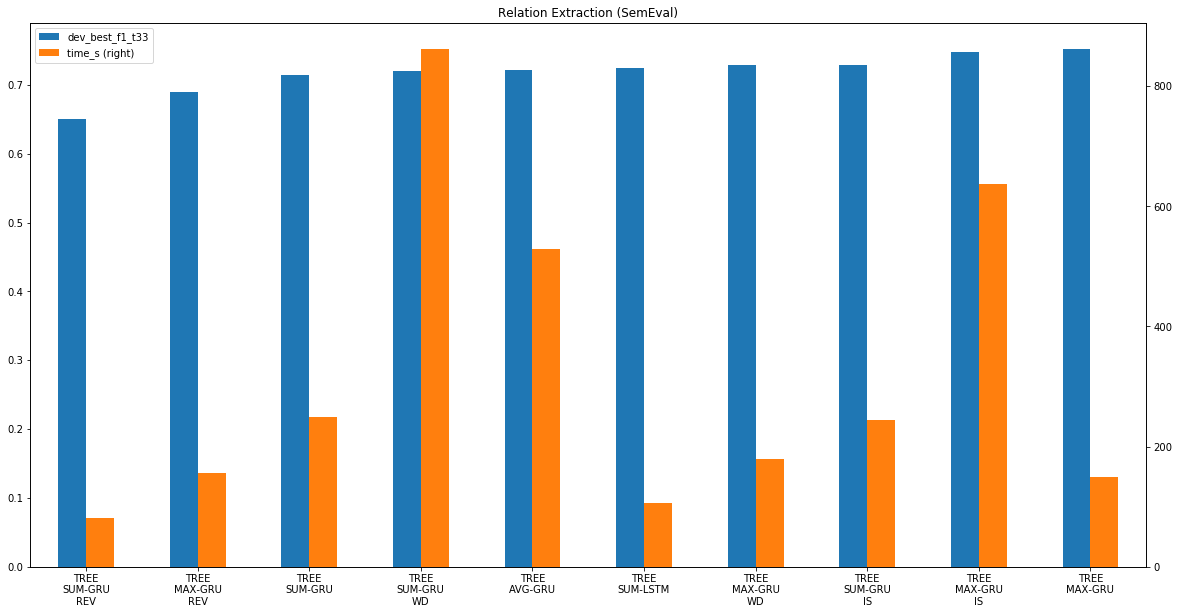

In [92]:
#print([v.replace(',', '\n') for v in cvs[p]])
#print({m: best_settings[m] for m in metrics[:2]})
#print(parameter_values_all)

df_plot = pd.DataFrame({m: best_settings[m][m].values for m in metrics[:2]}, index=[v.replace(':', '\n') for v in parameter_values_all]).sort_values(by=metrics[0]) #.sort_index() # 
#axes = df_plot.plot.bar(rot=0, subplots=True, figsize=(20, 10))
axes = df_plot.plot.bar(rot=0, secondary_y=metrics[1], figsize=(20, 10))
plt.title(map_task_long[task])#, y=y_suptitle)
#for m in metrics:
#    axes = df_plot.plot.bar(rot=0, y=m, figsize=(20, 5))
#axes[1].legend(loc=2) 

In [78]:
#cols_group = ['l', 'm']
#df_all[metrics_all + cols_group].groupby(cols_group).mean()
res = df_all[metrics + parameters + [COLUMN_RUN, COLUMN_DFIDX]].set_index(parameters)
res[:100]

dev_best_f1_t33  \
m        l    str st      fc   nfv vvr vvz lr                        
FLAT:GRU SPAN RNN 200     750  F   F   F   0.001          0.767738   
                                           0.001          0.767189   
                  100,100 500  T   F   F   0.003          0.755934   
                                           0.003          0.752754   
                  250     700  F   F   F   0.003          0.772014   
                                           0.003          0.781497   
                  150     800  F   F   F   0.003          0.795400   
                                           0.003          0.796827   
                  250     600  F   F   F   0.0003         0.780133   
                                           0.0003         0.777039   
                  100,100 700  F   F   F   0.0003         0.764208   
                                           0.0003         0.769599   
                  250     1000 F   F   F   0.003          0.772229   
                                           0.003          0.779049   
                          500  F   F   F   0.0003         0.794934   
                                           0.0003         0.793670   
                  200,200 1000 T   F   F   0.001          0.759080   
                                           0.001          0.761094   
                  200     600  F   F   F   0.0003         0.779126   
                                           0.0003         0.772865   
                          750  T   F   F   0.0003         0.761446   
                                           0.0003         0.773687   
                  200,200 700  F   F   T   0.0003         0.777308   
                                           0.0003         0.761094   
                          1000 F   F   T   0.001          0.784672   
                                           0.001          0.784625   
                  200     500  T   F   F   0.003          0.756724   
                                           0.003          0.760000   
                          600  F   F   T   0.0003         0.787770   
                                           0.0003         0.778729   
                  200,200 700  F   F   T   0.001          0.784748   
                                           0.001          0.782075   
                  200     1000 F   F   F   0.001          0.765701   
                                           0.001          0.778922   
                  100,100 1000 F   F   T   0.001          0.789189   
                                           0.001          0.797084   
                  150     500  F   F   T   0.0003         0.773494   
                                           0.0003         0.790698   
                  100,100 1000 F   F   F   0.003          0.776284   
                                           0.003          0.773918   
                          800  F   F   F   0.003          0.777913   
                                           0.003          0.787584   
                  200     500  F   F   T   0.003          0.790244   
                                           0.003          0.779661   
                          750  F   F   T   0.003          0.770542   
                                           0.003          0.773802   
                          600  F   F   T   0.0003         0.765165   
                                           0.0003         0.772289   
                  150,150 700  F   F   T   0.0003         0.783030   
                                           0.0003         0.793208   
                  200,200 600  F   F   T   0.003          0.788509   
                                           0.003          0.791792   
                                       F   0.003          0.780578   
                                           0.003          0.765701   
                  150,150 700  T   F   F   0.0003         0.778934   
                                           0.0003         0.7

In [66]:
from sklearn.utils import resample
def bootstrap_5th_percentile(data, n_bootstraps):
    bootstraps = []
    for _ in xrange(n_bootstraps):
        # Sample with replacement from data
        samples = resample(data)
        # Then we take the fifth percentile!
        bootstraps.append(np.percentile(samples, len(data) * 0.1))
    return pd.Series(bootstraps)
#values = res.xs(('NO', 'NO'))['pearson']
#bootstraps = bootstrap_5th_percentile(values, 10000)
#bootstraps.hist()

In [67]:
#df_all.boxplot(by=parameters, column=metrics_performance, figsize=(40,20), notch=True)

In [68]:
#for m in metrics_resources:
#    df_all.boxplot(by=parameters, column=m, figsize=(10,5))

In [69]:
res.groupby(parameters).mean()

dev_best_f1_t33  \
m             st      fc   dir   l      nfv vvr vvz                    
AVG-GRU       100,100 1000 RECNN DIRECT F   F   F           0.652891   
                                                T           0.650771   
                                 EDGES  F   F   F           0.546679   
                                                T           0.535764   
                      500  RECNN DIRECT F   F   F           0.655549   
                                                T           0.670607   
                                 EDGES  F   F   F           0.629553   
                                                T           0.536462   
                      600  RECNN DIRECT F   F   F           0.682309   
                                                T           0.673891   
                                 EDGES  F   F   T           0.587704   
                      700  RECNN DIRECT F   F   F           0.641084   
                                 EDGES  F   F   F           0.581689   
                      750  RECNN DIRECT F   F   F           0.656691   
                                                T           0.653480   
                      800  RECNN DIRECT F   F   T           0.649990   
                                 EDGES  F   F   F           0.510631   
                                                T           0.597778   
              150     1000 RECNN DIRECT F   F   T           0.655909   
                                 EDGES  F   F   F           0.515120   
                      500  RECNN DIRECT F   F   F           0.667812   
                                                T           0.683341   
                                 EDGES  F   F   F           0.566505   
                                                T           0.656838   
                      600  RECNN DIRECT F   F   F           0.664173   
                                 EDGES  F   F   T           0.599583   
                      700  RECNN DIRECT F   F   T           0.647622   
                                 EDGES  F   F   F           0.569792   
                      750  RECNN DIRECT F   F   T           0.653137   
                                 EDGES  F   F   F           0.597775   
                      800  RECNN DIRECT F   F   T           0.641077   
              150,150 1000 RECNN DIRECT F   F   F           0.651793   
                                                T           0.666554   
                                 EDGES  F   F   T           0.556548   
                      500  RECNN DIRECT F   F   F           0.664327   
                                                T           0.646065   
                                 EDGES  F   F   F           0.602963   
                                                T           0.556948   
                      600  RECNN DIRECT F   F   F           0.649273   
                                                T           0.662299   
                                 EDGES  F   F   T           0.533772   
                      700  RECNN DIRECT F   F   F           0.630289   
                                                T           0.663461   
                                 EDGES  F   F   F           0.558301   
                                                T           0.534325   
                      750  RECNN DIRECT F   F   F           0.639908   
                                 EDGES  F   F   T           0.624008   
                      800  RECNN DIRECT F   F   F           0.673665   
                                                T           0.651364   
                                 EDGES  F   F   T           0.631130   
              200     1000 RECNN DIRECT F   F   F           0.649161   
                                                T           0.639049   
                                 EDGES  F   F   F           0.541142   
                                                T           0.692711   
                     

In [74]:
#current_values = {'l': ['D', 'E'], 'm': ['SUM', 'MAX', 'GRU', 'SUM-GRU', 'MAX-GRU']}
#current_values = {p: list(set(df_all[p])) for p in parameters}
#current_values

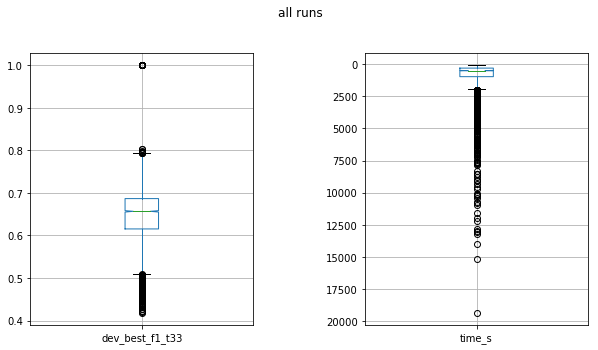

In [71]:
from matplotlib import rcParams
# final
#figsize = (4.5, 3)
# debug
figsize = (10, 5)


current_metrics = metrics



#rcParams['axes.titlepad'] = 20 
#rcParams['axes.titlepad'] = 20 
images = {}
bootstrap=10000
#rcParams.update({'figure.autolayout': True})

fig_merged, axs = plt.subplots(1, len(current_metrics), figsize=figsize)
for i, m in enumerate(current_metrics):
    res.boxplot(column=m, figsize=(figsize[i] / len(current_metrics), figsize[1]), ax=axs[i], bootstrap=bootstrap, notch=True)
    if m in metrics_inverted:
        axs[i].invert_yaxis()

#axs[0].invert_yaxis()
#axs[0].minorticks_on()
#axs[0].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
#res.boxplot(column='test_pearson_r', figsize=(figsize[0] / 2, figsize[1]), ax=axs[1], bootstrap=bootstrap, notch=True)
#axs[1].minorticks_on()
#axs[1].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
fig_merged.suptitle('all runs', y=1.01)
plt.subplots_adjust(wspace=0.5)
images['fig_merged'] = fig_merged

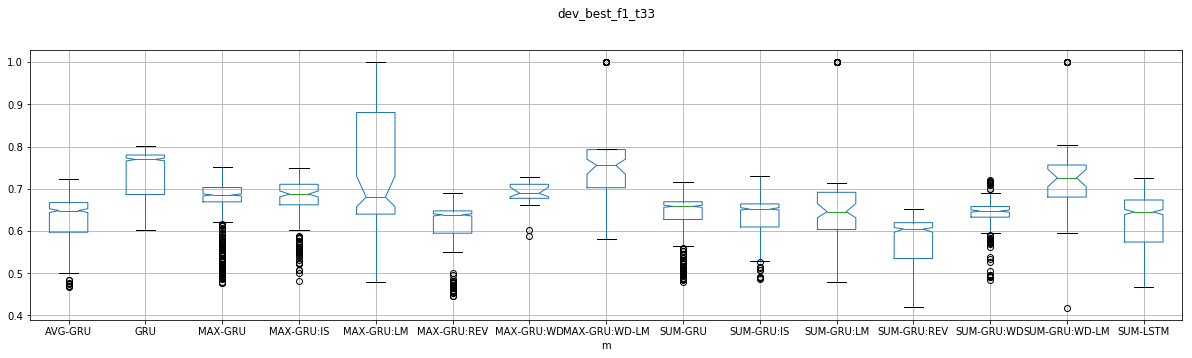

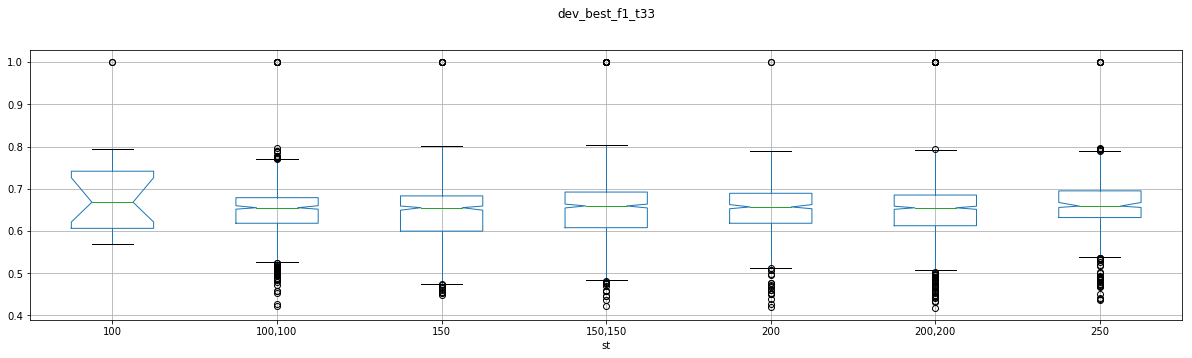

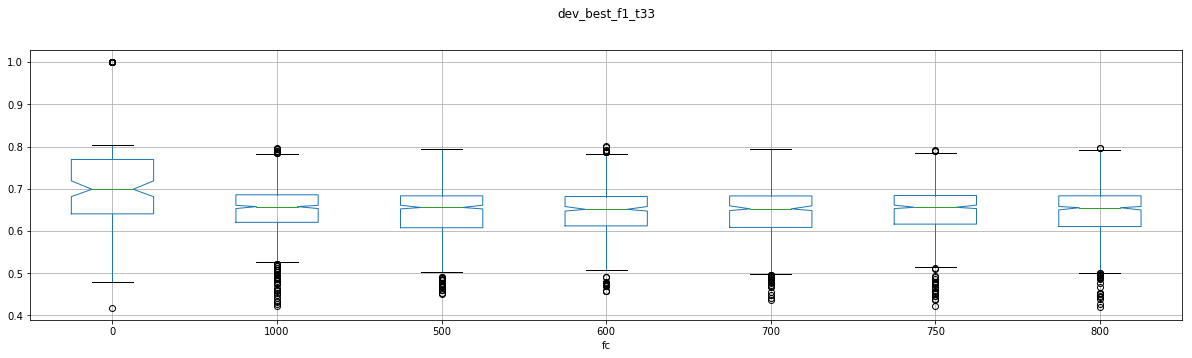

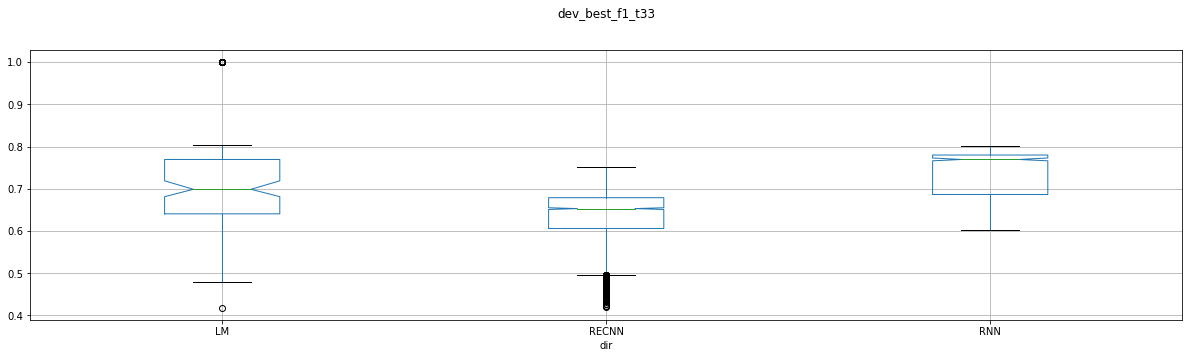

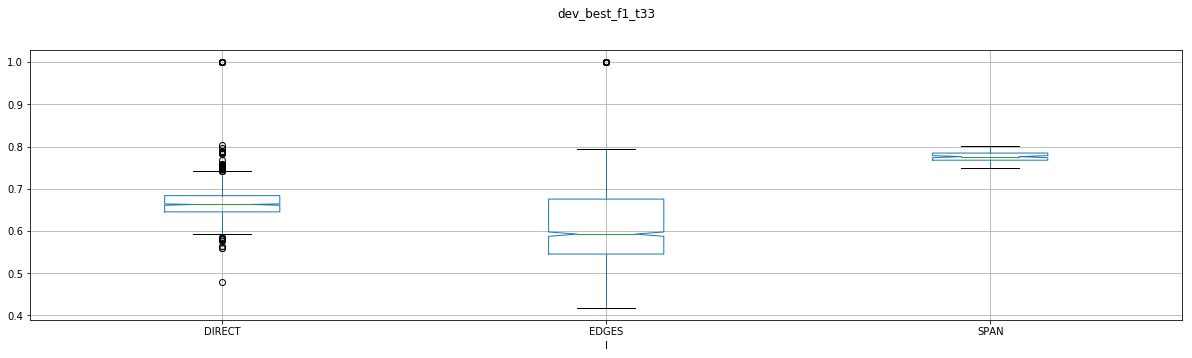

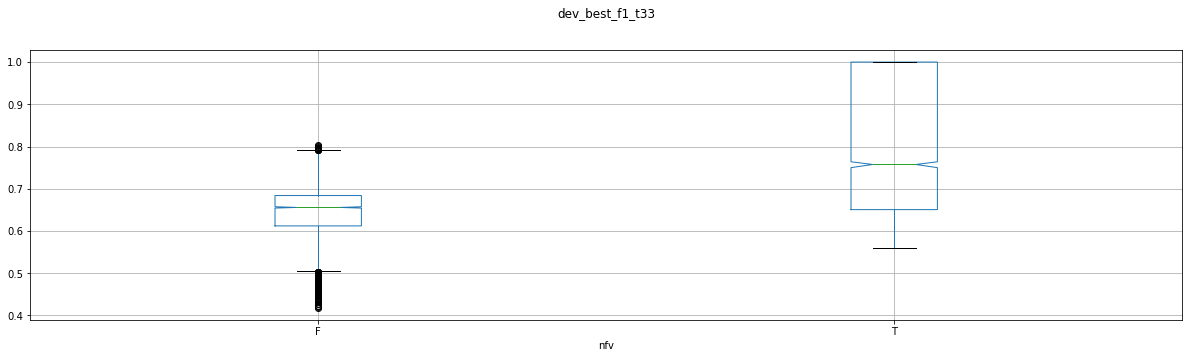

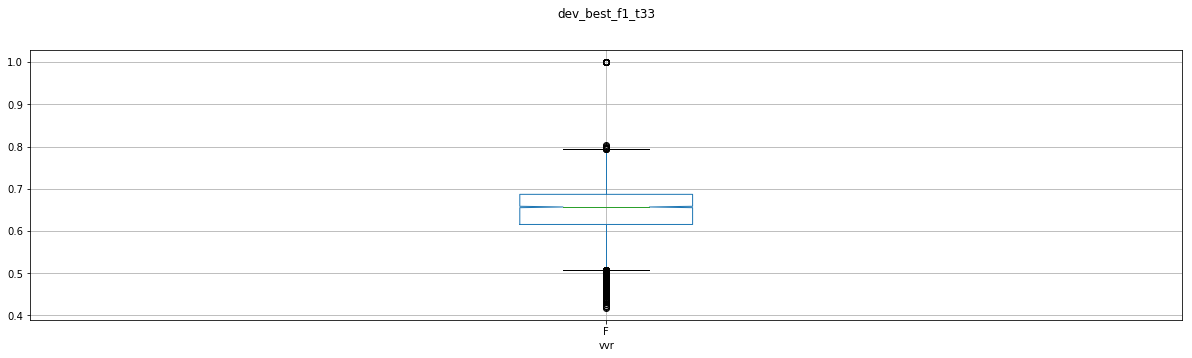

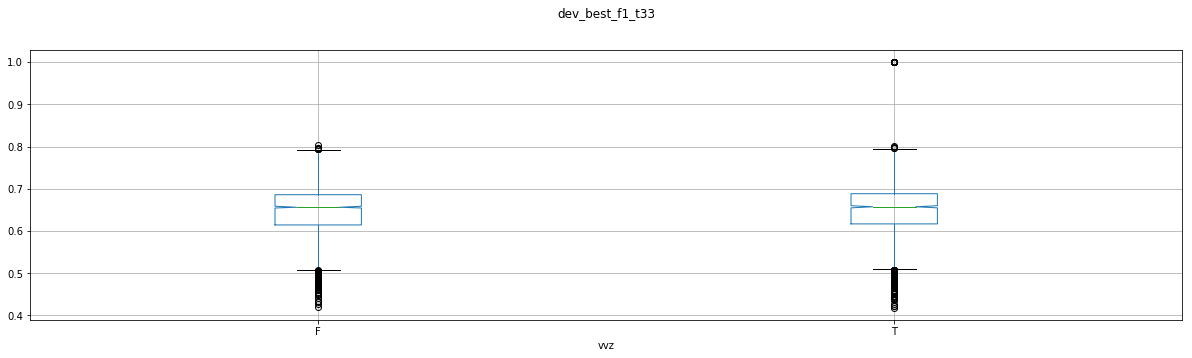

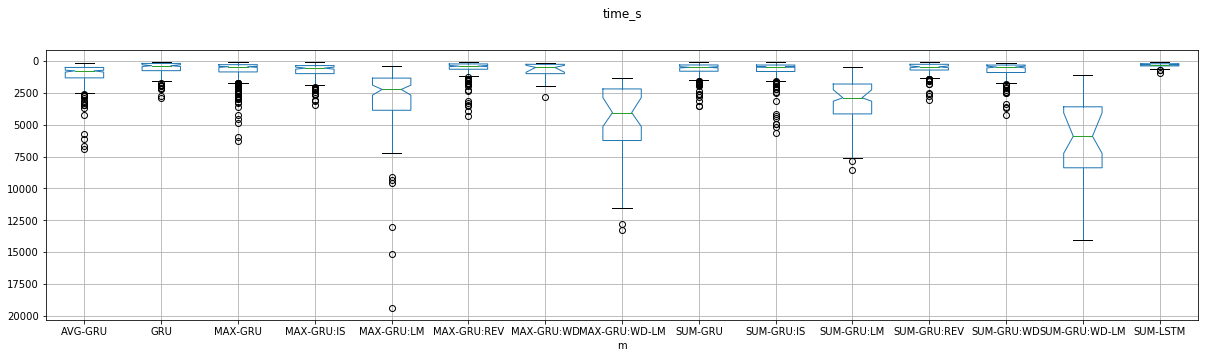

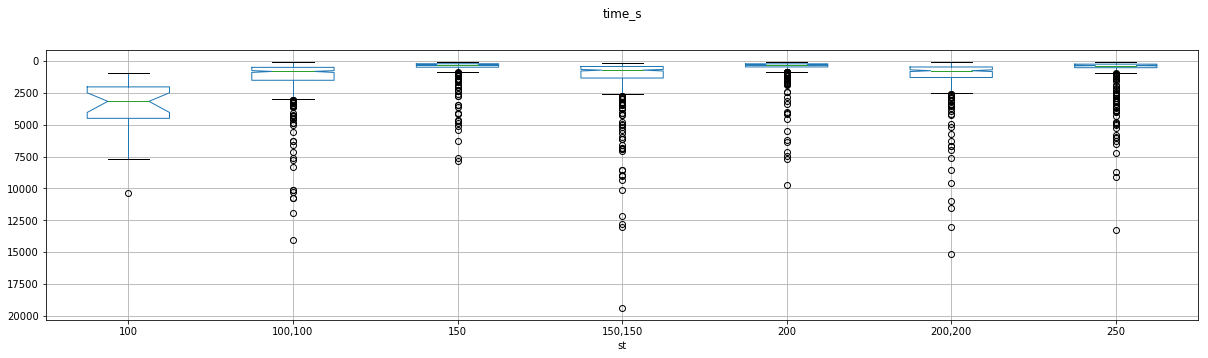

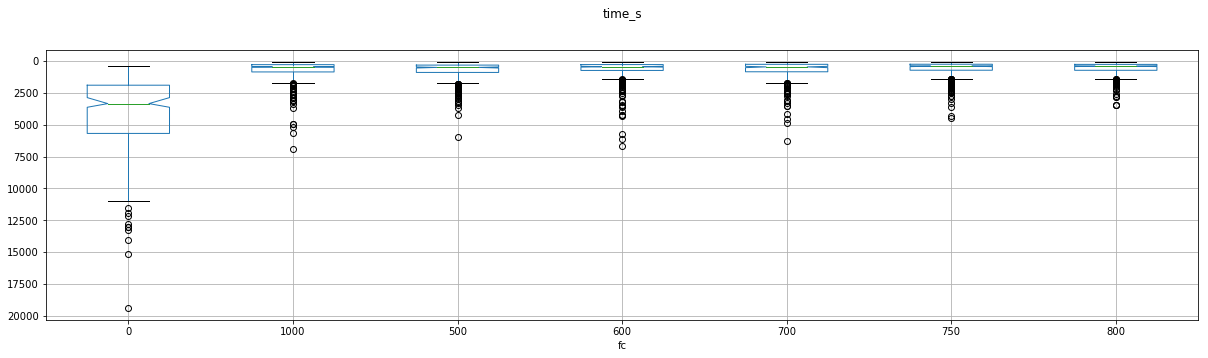

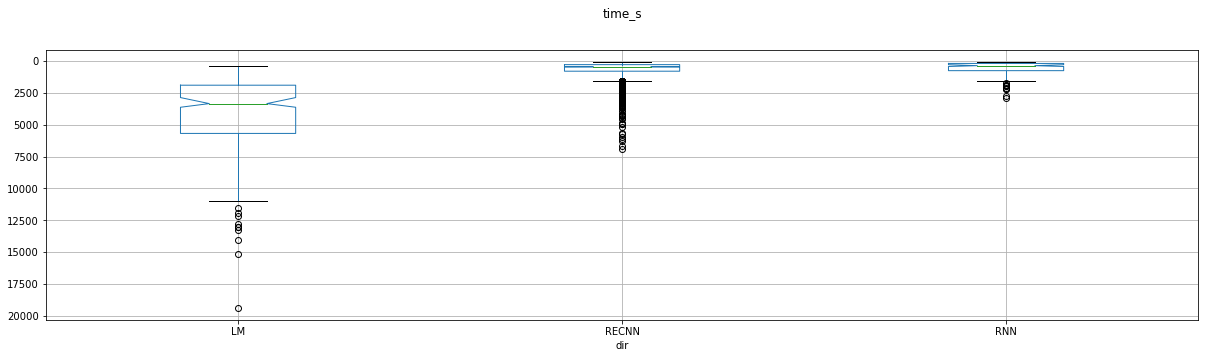

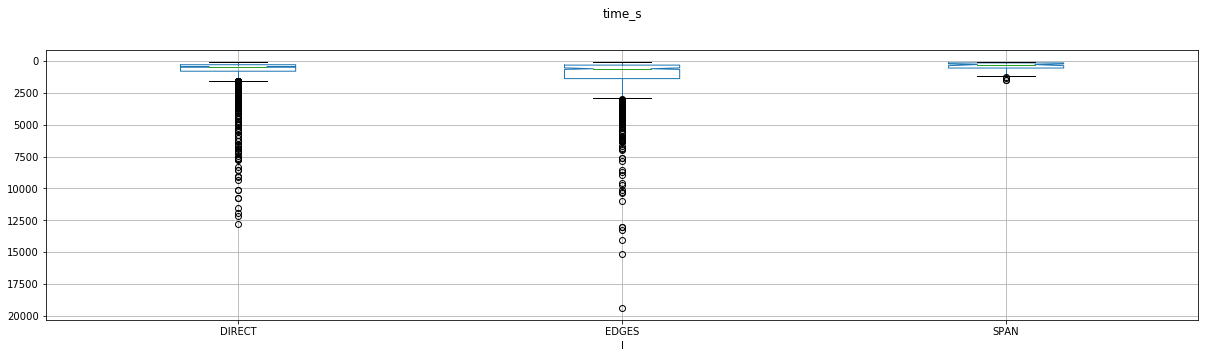

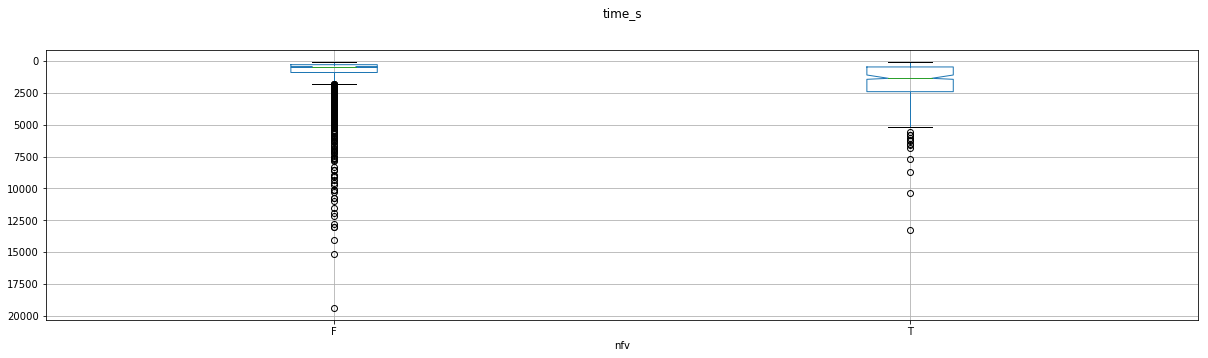

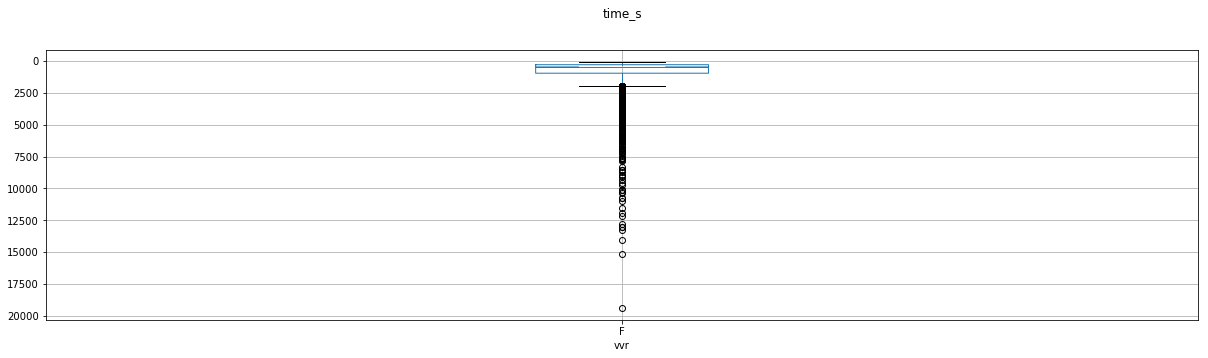

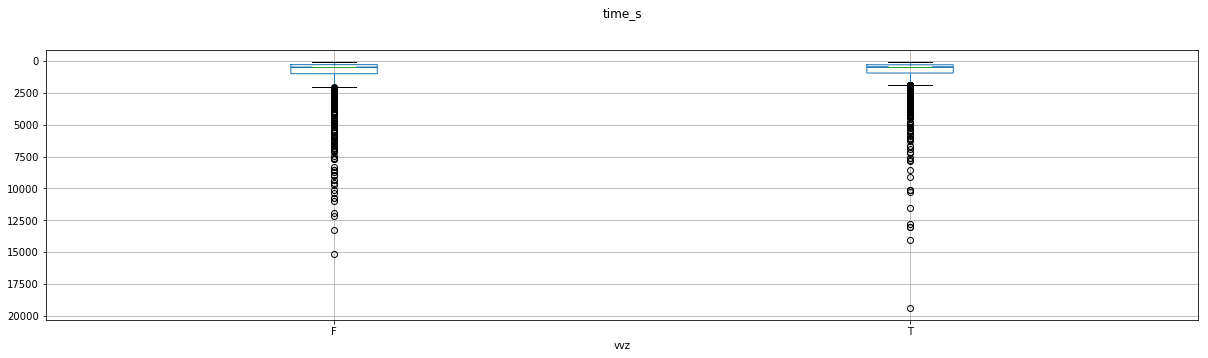

In [73]:
figsize = (20, 5)

y_title = 1.0
y_suptitle = 1.1

current_parameters = parameters[:2]
remaining_parameters = parameters[2:]
# use short versions

#levels = ['order aware', 'dependency available']
#other_level = {levels[0]: levels[1], levels[1]: levels[0]}
#other_parameter = {current_parameters[0]: current_parameters[1], current_parameters[1]:current_parameters[0]}

def param_long(param):
    #return ''.join([w[0].upper() for w in param.split()])
    return map_param_long.get(param, param)

def boxplot_sorted(df, by, column, **kwargs):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    return df2[meds.index].boxplot(rot=90, **kwargs)

current_values = get_current_values(df_all)

for m in current_metrics:
    for p in parameters:
        if len(current_values[p]) > 1:
            axs = res.boxplot(column=m, by=p, figsize=figsize, bootstrap=bootstrap, notch=True)
            if m in metrics_inverted:
                axs.invert_yaxis()
            #axs.minorticks_on()
            #axs.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
            plt.title(m, y=y_suptitle)
            fig_sep = axs.get_figure()
            fig_sep.suptitle('')
            images['fig_sep_'+m] = fig_sep




test_pearson_r
time_s


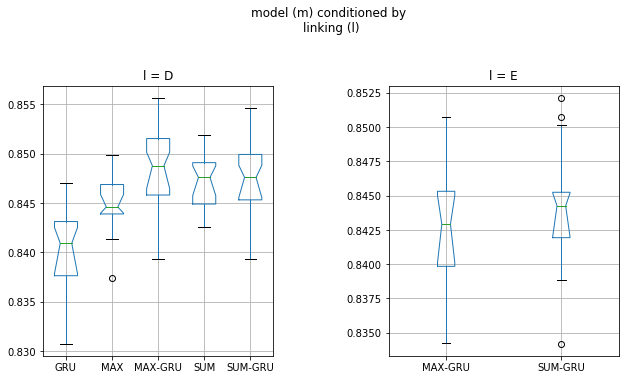

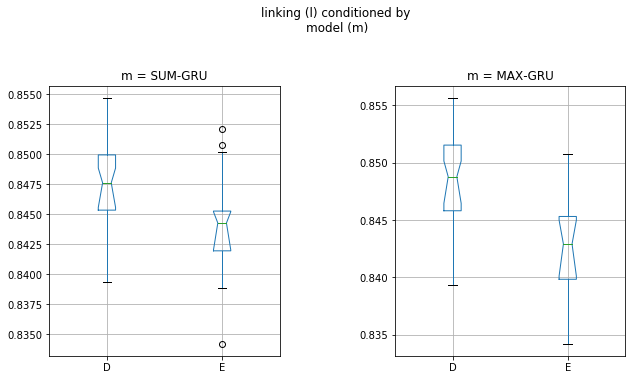

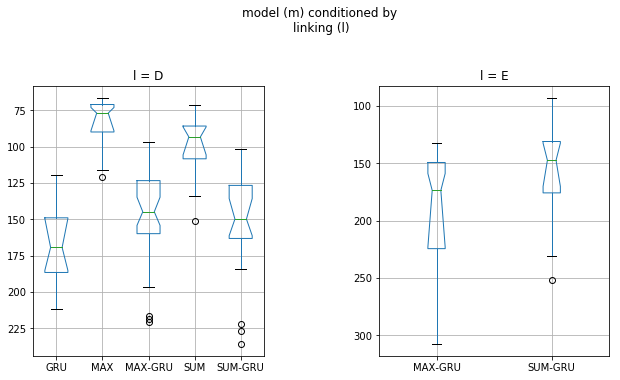

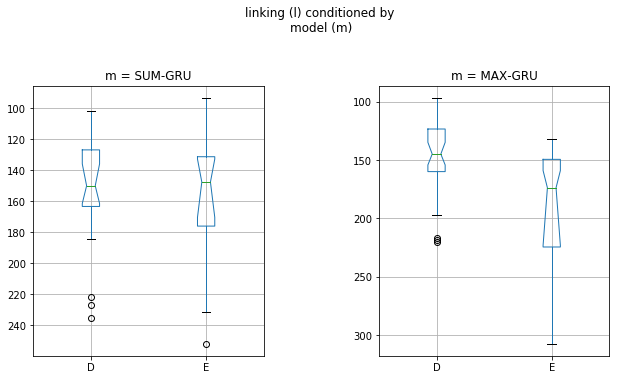

In [20]:
for m in current_metrics:
    print(m)
    for parameter in current_parameters:
        values = current_values[parameter]
        # collect values where other parameters has more then one values
        values_selected = []
        for i, v in enumerate(values):
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) > 1:
                values_selected.append(v)
        
        fig_sep, axs_sep = plt.subplots(1,len(values_selected), figsize=figsize)
        for i, v in enumerate(values_selected):

            #res.xs(v, level=parameter).boxplot(column=['pearson'], by=[other_parameter[parameter]], ax=axs_sep[0], bootstrap=bootstrap, notch=True)
            #axs_sep[0].set_title('pearson', y=y_title)
            #axs_sep[0].set_xlabel('')
            #print(res.xs(v, level=parameter)[m].groupby([other_parameter[parameter]]).count())
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) == 1:
                continue
            res.xs(v, level=parameter).boxplot(column=[m], by=[other_parameter[parameter]], ax=axs_sep[i], bootstrap=bootstrap, notch=True)
            axs_sep[i].set_title('%s = %s' % (parameter, v), y=y_title)
            axs_sep[i].set_xlabel('')
            if m in metrics_inverted:
                axs_sep[i].invert_yaxis()
        fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (param_long(other_parameter[parameter]), other_parameter[parameter], param_long(parameter), parameter), y=y_suptitle + 0.02)
        #fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (other_parameter[parameter], other_parameter[parameter], parameter, parameter), y=y_suptitle + 0.02)
        #plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.subplots_adjust(wspace=0.5)
        images['fig_sep_cond_%s' % other_parameter[parameter].split()[0]] = fig_sep


In [84]:
#import numpy
#from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
#from math import sqrt
#import scipy.stats as st

def bootstrap_convidence(values, n_iterations=1000, alpha=0.95):
    #values = res.xs(('NO', 'NO'))['pearson']
    mean_b = np.mean(values)
    std_b = np.std(values)
    n_b_root = sqrt(len(values))
    # configure bootstrap
    #n_iterations = 10000
    n_size = int(len(values) * 0.10)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        samples = resample(values, n_samples=n_size)
        t_i = (np.mean(samples) - mean_b) * n_b_root / np.std(samples)
        stats.append(t_i)
    # plot scores
    #pyplot.hist(stats)
    #pyplot.show()
    
    # confidence intervals
    #print(stats)
    #p_lower = ((1.0-alpha)/2.0) * 100
    p_lower = (alpha/2.) * 100
    #p = (alpha / 2.0) * 100
    lower = np.percentile(stats, p_lower)
    #lower = st.t._ppf(p_lower, n_iterations-1)
    #print('lower %.2f: %.3f' % (p_lower, lower))
    #p_upper = (alpha+((1.0-alpha)/2.0)) * 100
    p_upper = (1.-alpha/2.) * 100
    #p = (1.0 - alpha / 2.0) * 100
    upper = np.percentile(stats, p_upper)
    #upper = st.t._ppf(p_upper, n_iterations-1)
    #print('upper %.1f: %.3f' % (p_upper, upper))
    c_intv = [mean_b + lower * std_b / n_b_root, mean_b + upper * std_b / n_b_root]
    return c_intv

#def mean_confidence(values, alpha=0.95):
#    return st.t.interval(alpha, len(values)-1, loc=np.mean(values), scale=st.sem(values))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


alpha = 0.5
for m in current_metrics:
    print('confidence intervalls for %s (%s):' % (m, ', '.join(current_parameters)))
    values = res[m]
    conf_simple = mean_confidence_interval(values, confidence=1-alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % ('ALL', 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
    c_boot = bootstrap_convidence(values, alpha=alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % ('ALL', 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
    #for setting in [('NO', 'NO'), ('NO', 'YES'), ('YES', 'NO'), ('YES', 'YES')]:
    for setting in sorted(set(res.index.values)):
        values = res.xs(setting)[m]
        conf_simple = mean_confidence_interval(values, confidence=1-alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % (str(setting), 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
        c_boot = bootstrap_convidence(values=values, alpha=alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % (str(setting), 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
print('finished')  


confidence intervalls for dev_best_f1_t33 (m, st):
ALL             50.0% confidence interval: 0.6504 and 0.6523 (0.0020) True naive
ALL             50.0% confidence interval: 0.6481 and 0.6543 (0.0062) True
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6504 and 0.6554 (0.0050) True naive


/home/arne/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6408 and 0.6607 (0.0199) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.5463 and 0.5471 (0.0008) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False naive


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6524 and 0.6587 (0.0064) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6630 and 0.6782 (0.0152) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.6204 and 0.6387 (0.0182) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: 0.5327 and 0.5403 (0.0076) True naive
('AVG-GRU', '100,100', '500

KeyboardInterrupt: 

In [13]:
# NOT NECESSARY! use res.xs instead

#df_all_temp = df_all[current_parameters + current_metrics + [COLUMN_RUN, COLUMN_DFIDX]]
#df_all_temp = df_all_temp[df_all_temp[current_parameters[0]] == current_values[current_parameters[0]][0]]

# all settings seperated
pivot = {}
for m in current_metrics:
    #df_all_m[m] = df_all[current_parameters + [m] + [COLUMN_RUN, COLUMN_DFIDX]]
    pivot[m] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX], columns=current_parameters)
#pivot['pearson'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])
#pivot['mse'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])

# separated by order aware
#pivot_merged = {'pearson':{}, 'mse':{}}
pivot_merged = {}
for m in current_metrics:
    pivot_merged[m] = {} 
    for p in current_parameters:
        pivot_merged[m][p] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX] + [other_parameter[p]], columns=[p])
#pivot_merged['pearson']['order aware'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
#pivot_merged['mse']['order aware'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
## spereated by dependency available
##pivot_dep = {}
#pivot_merged['pearson']['dependency available'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
#pivot_merged['mse']['dependency available'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
##pivot['mse'] #['NO', 'NO'] - pivot_mse['NO', 'YES']
##pivot_['pearson']['dependency available']['NO']
#pivot['mse'][:10]

#pivot['dev_best_pearson_r']
#pivot_merged['dev_best_pearson_r']['m']
#df_all_temp
#df_all_temp[df_all_temp['l'] == 'E']

In [107]:
best_settings = {}
for m in metrics:
    best_settings[m] = df_all.sort_values(metrics[0], ascending=False).drop_duplicates(parameters).iloc[0]
best_settings[metrics[0]][parameters]

m      SUM-GRU:WD-LM
st           150,150
fc                 0
dir               LM
l             DIRECT
nfv                F
vvr                F
vvz                F
Name: 3101, dtype: object

In [86]:
p_threshold = 0.01
print('individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < %s)' % p_threshold)
parameter_settings = sorted(set(res.index.values
for m in current_metrics:
    print
    print(m)
    _res = []
    for i, s1 in enumerate(parameter_settings):
        for s2 in parameter_settings[i+1:]:
            nbr_equal_params = sum(map(lambda x: x[0] == x[1], zip(s1, s2)))
            nbr_changed_params = (len(current_parameters) - nbr_equal_params)
            tabs = ''.join(['>'] * nbr_changed_params)
            #%-15s %.1f
            #if s1 != s2:
            #dif = pivot[m][s2[0], s2[1]].mean() - pivot[m][s1[0], s1[1]].mean()
            dif = res.xs(s2)[m].mean() - res.xs(s1)[m].mean()
            per = (dif / res.xs(s1)[m].mean()) * 100
            #ttest = stats.ttest_ind(pivot[m][s1[0], s1[1]], pivot[m][s2[0], s2[1]], equal_var=False)
            ttest = stats.ttest_ind(res.xs(s1)[m], res.xs(s2)[m], equal_var=False)
            _res.append({'tabs': tabs, 'setting_a': str(s1), 'setting_b': str(s2), 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': per, 'nbr_changed_params': nbr_changed_params})
            #_res.append('%s %-18s -> %-20s %10.4f   %.4f    dif=%8.4f' % (tabs, str(s1), str(s2), ttest[0], ttest[1], dif))
    #print('\n'.join(sorted(_res)))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{tabs} {setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))
    

individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < 0.01)

dev_best_f1_t33


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


KeyboardInterrupt: 

In [15]:
print('aggregated parameter change')
for m in current_metrics:
    print
    print(m)
    _res = []
    for parameter in current_parameters:
        param_values = current_values[parameter]
        if len(param_values) <= 1:
            continue
        data = []
        for v in param_values:
            values = numpy.sort(res.xs(v, level=parameter)[m].values)
            #values = numpy.sort(pivot_merged[m][parameter][v].values)
            mean = values.mean()
            #print(pivot_merged[m][parameter][v])
            data.append((v, mean, values))
        data = sorted(data, key=lambda x: x[0])#, reverse=True)
        #mean_NO = pivot_merged[m][parameter]['NO'].mean()
        #mean_YES = pivot_merged[m][parameter]['YES'].mean()
        mean_a = data[0]
        mean_b = data[1]
        for i, data_a in enumerate(data):
            for data_b in data[i+1:]:
                #mean_dif = mean_YES - mean_NO
                #mean_dif = means[1][0] - means[0][0]
                dif = data_b[1] - data_a[1]
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[m][parameter]['YES'], equal_var=False)
                ttest = stats.ttest_ind(data_a[2], data_b[2], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  (%.4f -> %.4f = %8.4f)' % (parameter, m, ttest[0], ttest[1], mean_NO, mean_YES, mean_dif))
                #print('(merged) %-5s %-10s -> %-10s %10.4f   %.4f  (%8.4f -> %8.4f = %8.4f)' % (parameter, data_a[0], data_b[0], ttest[0], ttest[1], data_a[1], data_b[1], mean_dif))
                _res.append({'parameter':parameter, 'setting_a': data_a[0], 'setting_b': data_b[0], 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': (dif / data_a[1]) * 100})
                #merged = 'order aware'
                #mean_dif = pivot_merged[measure][parameter]['YES'].mean() - pivot_merged[measure][parameter]['NO'].mean()
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[measure][parameter]['YES'], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  %8.4f' % (parameter, measure, ttest[0], ttest[1], mean_dif))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{parameter}\t{setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))

aggregated parameter change

test_pearson_r
m	GRU                -> SUM               	   -7.1515   0.0000    dif=  0.0071  0.85%	X
m	GRU                -> SUM-GRU           	   -5.5192   0.0000    dif=  0.0057  0.68%	X
m	GRU                -> MAX-GRU           	   -4.5825   0.0000    dif=  0.0051  0.61%	X
m	GRU                -> MAX               	   -4.7452   0.0000    dif=  0.0048  0.57%	X
m	MAX                -> SUM               	   -3.2687   0.0020    dif=  0.0024  0.28%	X
l	D                  -> E                 	    3.2428   0.0016    dif= -0.0023 -0.27%	X
m	MAX-GRU            -> SUM               	   -2.2740   0.0259    dif=  0.0020  0.24%
m	SUM                -> SUM-GRU           	    1.8211   0.0729    dif= -0.0014 -0.17%
m	MAX                -> SUM-GRU           	   -1.2411   0.2188    dif=  0.0010  0.12%
m	MAX-GRU            -> SUM-GRU           	   -0.6405   0.5234    dif=  0.0006  0.07%
m	MAX                -> MAX-GRU           	   -0.4238   0.6729    dif=  0.0004  0.04